In [ ]:
#kaggle ekleme
!pip install -q Kaggle

In [ ]:
#dosya yükleme
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehmetmustafazelik","key":"3e232d127b1b149cb69819ddfd37dcc3"}'}

In [ ]:
#kaggle dosyası oluşturma
! mkdir ~/.kaggle

In [ ]:
#kaggle.json dosyasının kopyasını oluşturma
! cp kaggle.json ~/.kaggle/

In [ ]:
#json'un hareket etme izni
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# kullanılacak datasetin eklenmesi
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:42<00:00, 91.7MB/s]
100% 2.29G/2.29G [00:43<00:00, 57.2MB/s]


In [ ]:
#datasetin çıkarılması
!unzip chest-xray-pneumonia.zip

In [ ]:
import numpy as np #Numpy kütüphanesinin import edilmesi
import pandas as pd # pandas kütüphanesinin import edilmesi

import os
for dirname, _, filenames in os.walk('/kaggle/input'):  #veri giriş dosyası
    for filename in filenames:    
        print(os.path.join(dirname, filename))          #gecerli dizindekitüm sonuçler çıktı olarak kaydedilir

In [ ]:
#gerekli kütüphaneleri ekleme
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Görüntüleri tercih edilen boyuta yeniden şekillendirme
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


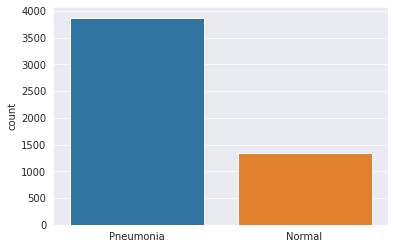

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

Text(0.5, 1.0, 'NORMAL')

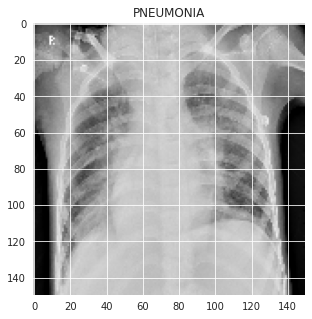

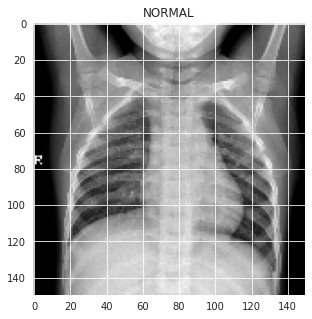

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
#diziler oluışturularak etiketlerlerle görüntüleri atıyoruz
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
#işlemi hızlandırmak için değerleri 0 ile 1 arasına düşürüyoruz
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
#ön işleme 
#görüntü boyutlarını girerek dizilere atıyoruz 
#etiketleride dizilere atıyoruz
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # dataset üzerinden giriş ortalamasını 0 olarak ayarla
        samplewise_center=False,  # her numunenin ortalamasını 0'a ayarlayın
        featurewise_std_normalization=False,  # girdileri veri kümesinin std'sine böl
        samplewise_std_normalization=False,  # her girişi std'sine böl
        zca_whitening=False,  # ZCA beyazlatma uygulayın
        rotation_range = 30,  # aralıktaki görüntüleri rastgele döndürün (derece, 0 ila 180)
        zoom_range = 0.2, # Rastgele görüntüyü yakınlaştır
        width_shift_range=0.1,  # görüntüleri yatay olarak rasgele kaydırma (toplam genişliğin kesri)
        height_shift_range=0.1,  # görüntüleri dikey olarak rastgele kaydır (toplam yüksekliğin kesri)
        horizontal_flip = True,  # görüntüleri rastgele çevir
        vertical_flip=False)  # görüntüleri rastgele çevir


datagen.fit(x_train)

In [ ]:
#modeli oluşturuyoruz
#model kullanarak CNNe uygun hale getirmek için filtrelemeler ve maxpool işlemlerini yapıyoruz
#batchnormalization girdileri normalleştiren katman
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
#reducelronplateau öğrenme oranınını arttırmak için kullanılır
#min_lr öğrenme oranının alt sınırı
#factor öğrenme oranının azalacağı faktör
#patience öğrenme oranının düşeceği sınır
#verbose mesaj güncelleme
#monitor izlenecek değer

In [ ]:
#model 12 defa dönecek epochs=5
#model eğitimi başlıyor
#her eğitimde 32 görüntü alacak
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 321s 2s/step - loss: 0.7232 - accuracy: 0.8265 - val_loss: 26.5901 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 322s 2s/step - loss: 0.2680 - accuracy: 0.8967 - val_loss: 25.2590 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9187
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 322s 2s/step - loss: 0.2368 - accuracy: 0.9187 - val_loss: 33.4266 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 322s 2s/step - loss: 0.1414 - accuracy: 0.9507 - val_loss: 20.7141 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 323s 2s/step - loss: 0.1428 - accuracy: 0.9509 - val_loss: 0.5408 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 6/12
163/163 [=======================

In [ ]:
#eğitilen modelin başarısı test ediliyor
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 10s 482ms/step - loss: 0.4071 - accuracy: 0.8333
Loss of the model is -  0.40707579255104065
20/20 [==============================] - 8s 411ms/step - loss: 0.4071 - accuracy: 0.8333
Accuracy of the model is -  83.33333134651184 %


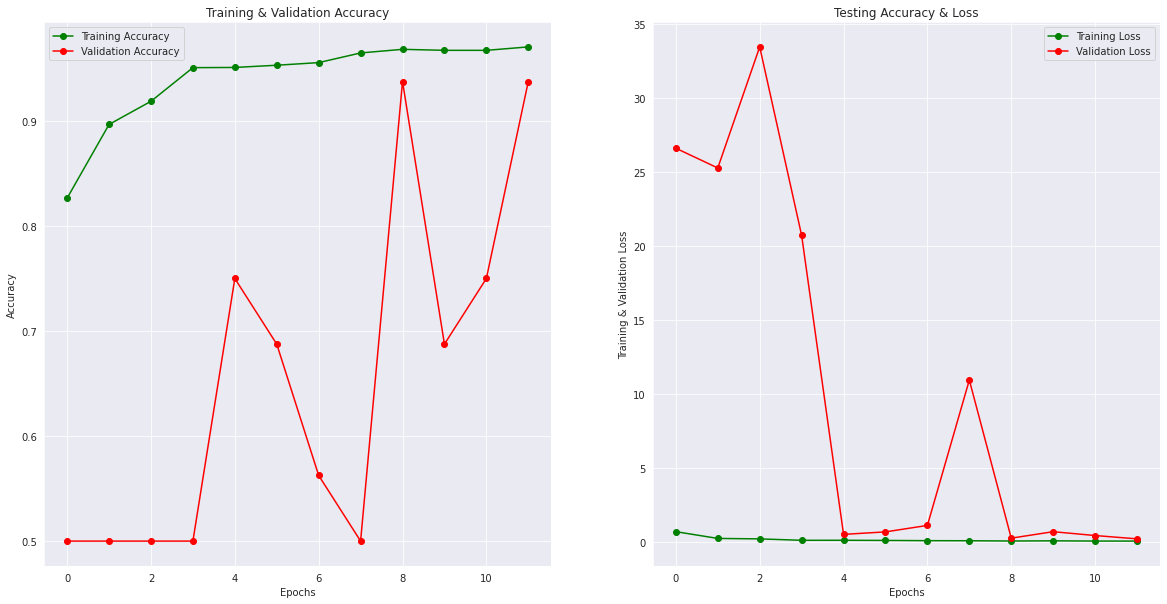

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()